# Applying the Model

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
img_md_subset = pd.read_csv('../../../Data/ifcb_ecotaxa_subset_merged.csv')
img_md_subset = img_md_subset.drop('Unnamed: 0', 1)

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
import glob, os

file_dir = '../../../Data/all_imagery/'

os.chdir(file_dir)
fn_list = []
for file in glob.glob("*.png"):
    fn_list.append(file)
    
print(len(fn_list))

fn_edit = [x[:-4] for x in fn_list]

available_subset = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(available_subset)

5158003


1328483

In [7]:
frac = 0.05
int(len(available_subset) * frac)

66424

In [8]:
class_id_dict = {'amphiprora': 0,
 'chaetoceros': 1,
 'chaetoceros_mediophyceae': 2,
 'chlorophytes': 3,
 'ciliophora': 4,
 'corethron': 5,
 'cryptophytes': 6,
 'cylindrotheca': 7,
 'dactyliosolen': 8,
 'dinoflagellate_i': 9,
 'dinoflagellate_ii': 10,
 'dinoflagellate_iii': 11,
 'dinophyceae': 12,
 'eucampia': 13,
 'eucampia_chain': 14,
 'general_centric_diatoms': 15,
 'general_dinoflagellates': 16,
 'general_pennate_diatoms': 17,
 'gymnodinium': 18,
 'haptophytes': 19,
 'katodinium': 20,
 'nitzschia_frigida': 21,
 'other': 22,
 'proboscia': 23,
 'pseudo_nitzschia_chain': 24,
 'silicoflagellates': 25,
 'small_unidentified_cells': 26,
 'tintinnida': 27,
 'unidenfitied_chain_pennates': 28,
 'unidentified_chain_centrics': 29,
 'unidentified_diatoms': 30,
 'unidentified_flagellates': 31,
 'unidentified_living_cells': 32,
 'unidentified_single_centrics': 33,
 'unidentified_single_pennates': 34,
 'torodinium':35,
 'guinardia': 36,
 'ceratium' : 37}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np

images = []
labels = []
merged_labels = []
original_labels = []

for index, row in available_subset.sample(frac=frac).iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images.append(image.img_to_array(img))
    labels.append(class_id_dict[row['merged_category']])
    merged_labels.append(row['merged_category'])
    original_labels.append(row['object_annotation_category'])
    
images = np.array(images)
labels = np.array(labels)
merged_labels = np.array(merged_labels)
original_labels = np.array(original_labels)

In [10]:
X_predict = images / 123
np.mean(X_predict), np.std(X_predict)

(1.0345078, 0.34433752)

In [11]:
from tensorflow import keras

model = keras.models.load_model('../model_weights.hdf5')

In [12]:
X_predict.shape

(66424, 150, 150, 1)

In [13]:
def generate_data(directory, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    while True:
        
        images = []
        labels = []
        merged_labels = []
        original_labels = []

        for index, row in available_subset.sample(frac=frac).iterrows():

            # TODO need to think about optimal size and that size actually corresponds to class
            # maybe add blackspace instead of interpolating because it is changing the morphology

            img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
            images.append(image.img_to_array(img))
            labels.append(class_id_dict[row['merged_category']])
            merged_labels.append(row['merged_category'])
            original_labels.append(row['object_annotation_category'])
        
        
        
        image_batch = []
        for b in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            image = cv2.resize(cv2.imread(sample[0]), INPUT_SHAPE)
            image_batch.append((image.astype(float) - 128) / 128)

        yield np.array(image_batch)

In [14]:
predictions = np.argmax(model.predict(X_predict), axis=1)

In [ ]:
model.predict_generator(generator = tile_gen.tile_generator(clean_px, batch_size=100, flatten=True, canopy=True), steps=len(clean_px) // 100, verbose=1)

In [15]:
classes, counts = np.unique(predictions, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34]),
 array([  178,    50,   495,  5522,   232,    53,  3052,   162,    45,
          509,   339,    19,    37,     2,     6,    20,    78,   636,
          237,   113,   901,  8469,    45,   255,    15, 18719,   123,
          155,  1919, 12857,  6790,  1066,  3325]))

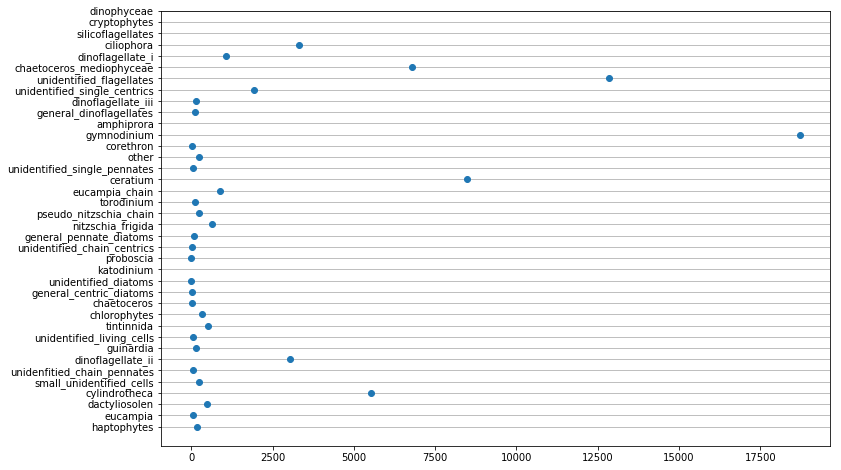

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(counts, classes)
ax.set_yticks(range(0,len(class_id_dict)))
ax.set_yticklabels(list(class_id_dict.keys()))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [23]:
classes, counts = np.unique(labels, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 array([  226,   171,    53,  4495,   309,    24,  2294,    95,    31,
          581,   439,    46,   523,     6,     3,     8,     9,    30,
          633,    48,    32,   810,  9594,    41,   167,   497, 23099,
            1,    79,    67,  1059,  9784,  5972,   805,  4378,     7,
            8]))

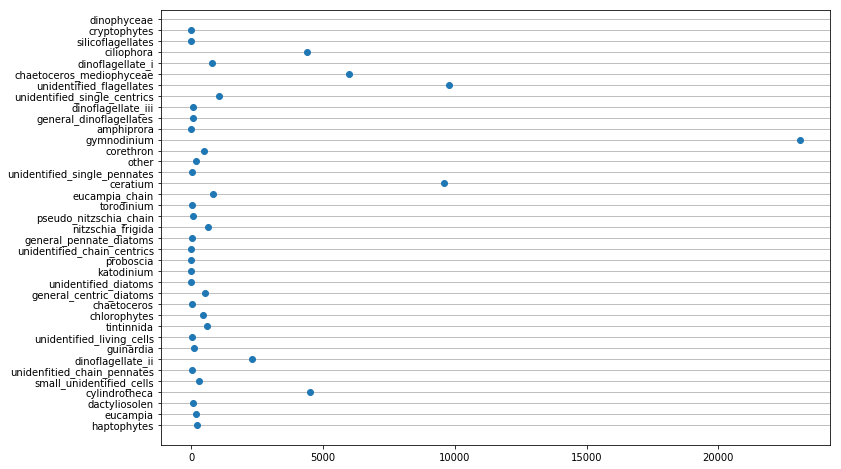

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(counts, classes)
ax.set_yticks(range(0,len(class_id_dict)))
ax.set_yticklabels(list(class_id_dict.keys()))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()